# Service optimization

In [1]:
import geopandas as gpd

blocks = gpd.read_parquet('./../data/blocks.parquet')
columns = [c for c in blocks.columns if 'capacity_' in c]
blocks = blocks[['geometry', 'population', 'site_area', *columns]].copy()
blocks.head(3)

,geometry,population,site_area,capacity_convenience,capacity_cafe,capacity_mall,capacity_pharmacy,capacity_bank,capacity_fuel,capacity_pitch,...,capacity_bus_station,capacity_bus_stop,capacity_pier,capacity_animal_shelter,capacity_prison,capacity_landfill,capacity_plant_nursery,capacity_greenhouse_complex,capacity_warehouse,capacity_machine_building_plant
id,,,,,,,,,,,,,,,,,,,,,
0,"POLYGON ((354918.622 6625258.829, 354901.464 6...",565.0,804466.712114,208.0,0.0,2216.0,20.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"POLYGON ((355412.142 6623378.149, 355411.7 662...",42.0,23173.129862,811.0,25.0,0.0,0.0,148.0,0.0,0.0,...,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"POLYGON ((353934.329 6625429.433, 353923.453 6...",19.0,363005.815802,0.0,0.0,0.0,0.0,0.0,501.0,0.0,...,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
import pandas as pd

accessibility_matrix = pd.read_pickle('./../data/accessibility_matrix.pickle')
accessibility_matrix.head()

/home/ivan/work/ovanes-projects/urban-planning-optimizer/blocksnet-fork/blocksnet/.venv/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,0,1,2,3,4,5,6,7,8,9,...,16310,16311,16312,16313,16314,16315,16316,16317,16318,16319
0,0.000000,18.718750,9.234375,17.21875,30.296875,27.390625,30.671875,23.281250,78.6875,81.2500,...,76.5625,102.5625,97.5000,132.250,130.8750,142.125,247.625,228.625,247.625,124.6250
1,17.859375,0.000000,19.015625,7.65625,20.281250,25.250000,25.234375,15.765625,76.8750,79.4375,...,74.6875,100.7500,95.6875,130.500,129.0000,140.250,245.875,226.875,245.875,112.5000
2,9.234375,20.796875,0.000000,20.21875,27.968750,25.062500,28.343750,20.953125,71.8750,74.4375,...,69.7500,95.8125,90.6875,125.500,124.0625,135.375,240.875,221.875,240.875,124.6250
3,15.937500,7.449219,18.421875,0.00000,21.109375,24.984375,27.781250,16.593750,76.3125,78.8125,...,74.1250,100.1875,95.0625,129.875,128.5000,139.750,245.250,226.250,245.250,113.3750
4,31.906250,19.765625,31.734375,21.28125,0.000000,21.781250,23.125000,15.429688,89.5625,92.1250,...,87.4375,113.5000,108.3750,143.125,141.7500,153.000,258.500,239.500,258.500,108.3125


### Select ID of optimized blocks

In [3]:
from blocksnet.enums import LandUse
blocks_lu = {
    1536 : LandUse.RESIDENTIAL
}

### Service distribution

In [4]:
basic_services = [
    "kindergarten",
    "school",
    "pharmacy",
    "market",
    "cafe",
    "playground",
    "post",
    "hairdresser",
    "bus_stop",
    "parking",
]
advanced_services = [
    "polyclinics",
    "hospital",
    "supermarket",
    "restaurant",
    "park",
    "convenience",
    "bank",
    "fuel",
    "police",
]
comfort_services = ["mall", "dog_park", "swimming_pool", "train_station"]


def get_service_weight(service_name):
    if service_name in basic_services:
        return 0.5714
    elif service_name in advanced_services:
        return 0.2857
    elif service_name in comfort_services:
        return 0.1429
    return 0

### Service types and weights

In [5]:
chosen_service_types = set(basic_services) | set(advanced_services) | set(comfort_services)
service_weights = {service_type: get_service_weight(service_type) for service_type in chosen_service_types if f'capacity_{service_type}' in blocks.columns}

### Initialize and run optimizer

In [6]:
from blocksnet.optimization.services import (
    TPEOptimizer,
    WeightedObjective,
    WeightedConstraints,
    Facade,
    BlockSolution,
    GradientChooser,
)
from tqdm import tqdm

var_adapter = BlockSolution(blocks_lu)

facade = Facade(
    blocks_lu=blocks_lu,
    blocks_df=blocks,
    accessibility_matrix=accessibility_matrix,
    var_adapter=var_adapter,
)

for service_type, weight in tqdm(service_weights.items()):
    facade.add_service_type(service_type, weight, blocks.rename(columns={f'capacity_{service_type}': 'capacity'})[['capacity']])

objective = WeightedObjective(num_params=facade.num_params, facade=facade, weights=service_weights, max_evals=50)

constraints = WeightedConstraints(num_params=facade.num_params, facade=facade)

tpe_optimizer = TPEOptimizer(
    objective=objective, constraints=constraints, vars_chooser=GradientChooser(facade, facade.num_params, 5)
)

best_x, best_val, perc, func_evals = tpe_optimizer.run(max_runs=1000, timeout=60000, initial_runs_num=1)

100%|██████████| 22/22 [03:47<00:00, 10.32s/it]
[I 2025-04-15 21:27:26,305] A new study created in memory with name: no-name-7b38c989-fd95-4261-8711-3e1477131fd5


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-04-15 21:27:34,657] Trial 0 finished with value: 2.7512454697365296 and parameters: {'x_0': 0, 'x_1': 0, 'x_2': 0, 'x_3': 0, 'x_4': 0, 'x_5': 0, 'x_6': 0, 'x_7': 0, 'x_8': 0, 'x_9': 0, 'x_10': 0, 'x_11': 0, 'x_12': 0, 'x_13': 0, 'x_14': 0, 'x_15': 0, 'x_16': 0, 'x_17': 0, 'x_18': 0, 'x_19': 0, 'x_20': 0, 'x_21': 0, 'x_22': 0, 'x_23': 0, 'x_24': 0, 'x_25': 0, 'x_26': 0, 'x_27': 0, 'x_28': 0, 'x_29': 0, 'x_30': 0, 'x_31': 0, 'x_32': 0, 'x_33': 0, 'x_34': 0, 'x_35': 0, 'x_36': 0, 'x_37': 0, 'x_38': 0, 'x_39': 0, 'x_40': 0, 'x_41': 0, 'x_42': 0, 'x_43': 0, 'x_44': 0, 'x_45': 0, 'x_46': 0, 'x_47': 0, 'x_48': 0, 'x_49': 0, 'x_50': 0, 'x_51': 0}. Best is trial 0 with value: 2.7512454697365296.
[I 2025-04-15 21:27:34,813] Trial 1 finished with value: 2.7512454697365305 and parameters: {'x_0': 0, 'x_1': 0, 'x_2': 0, 'x_7': 0, 'x_8': 0, 'x_9': 0, 'x_10': 0, 'x_11': 0, 'x_12': 0, 'x_13': 0, 'x_14': 0, 'x_15': 0, 'x_16': 0, 'x_22': 0, 'x_23': 0, 'x_24': 0, 'x_25': 0, 'x_26': 0, 'x_27': 0, 

Convert to services dataframe

In [7]:
solution_df = facade.solution_to_services_df(best_x)
solution_df.to_csv(f'tpe_services.csv')
solution_df.head(5)

,block_id,service_type,site_area,build_floor_area,capacity,count
0,1536,bus_stop,7.0,0.0,20,1
2,1536,bus_stop,10.0,0.0,50,1
3,1536,market,3000.0,6000.0,3000,1
7,1536,post,50.0,200.0,40,136
8,1536,post,60.0,240.0,60,32


### Visualization

In [8]:
import matplotlib.pyplot as plt


def plot_df(df):
    df_called_obj = df.loc[df["called_obj"] == True]

    plt.scatter(df_called_obj["func_evals"], df_called_obj["best_val"], c="red", s=5)

    df_called_obj = pd.concat(
        [pd.DataFrame([[-1, None, 0, 0, None, 0, False, 0]], columns=df_called_obj.columns), df_called_obj]
    )
    plt.plot(
        df_called_obj["func_evals"], df_called_obj["best_val"], label="Best Value (TPE)", color="blue", linewidth=1
    )
    # Добавление точек с цветом в зависимости от 'called_obj'
    # Настройка осей и заголовка
    plt.xlabel("Number of objective evaluation")
    plt.ylabel("Best Value")
    plt.title("Best Value Across Trials")
    plt.legend()
    plt.grid(True)

    # Отображение графика
    plt.show()

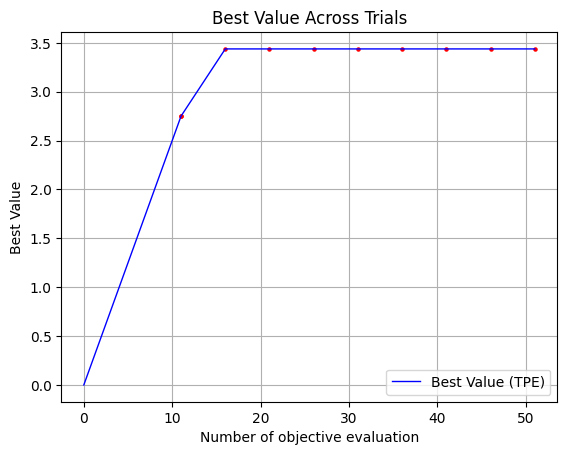

In [9]:
tpe_df = pd.read_csv("tpe_trials.csv")
plot_df(tpe_df)